In [13]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import seaborn as sns
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Differences in lineage characteristics between cross-border and domestic introductions.
We measure epidemiologically relevent characterisitics of transmission lineages in San Diego and assess whether there are significant differences between lineages which cross the border and those that done.

Load in the jumps from the discrete state analysis which used actual location states. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST.

In [2]:
jumps = pd.read_csv( "../data/2021-08-30_fixed_eponential_discrete.Location.history.csv" )
jumps["date"] = jumps["time"].apply( dec_to_date )
jumps["date"] = jumps["date"].dt.normalize()
#jumps = jumps.loc[jumps["treeId"]>jumps["treeId"].max()*0.1]
jumps.head()

,treeId,startLocation,endLocation,time,date
0,50000,Los Angeles,Rest of World,2021.132618,2021-02-18
1,50000,Los Angeles,Rest of World,2020.778415,2020-10-11
2,50000,United States,Rest of World,2020.909225,2020-11-28
3,50000,United States,Rest of World,2021.119496,2021-02-13
4,50000,United States,Rest of World,2020.949627,2020-12-13


Calculate the number of jumps between San Diego and each other discrete state.

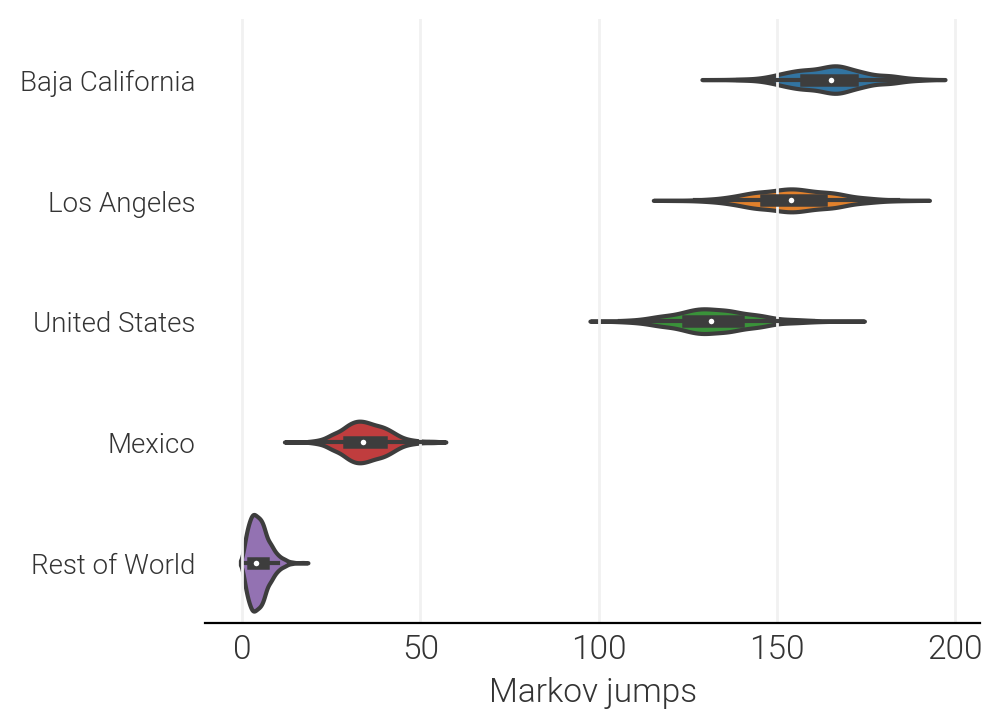

In [3]:
sd_jumps = jumps.loc[(jumps["startLocation"]=="San Diego")|(jumps["endLocation"]=="San Diego")].copy()

sd_jumps.loc[sd_jumps["endLocation"]=="San Diego","endLocation"] = sd_jumps["startLocation"]
sd_jumps["startLocation"] = "San Diego"

sd_jumps = sd_jumps.groupby( ["treeId","endLocation"] )["time"].agg( "count" ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
sns.violinplot( y="endLocation", x="time", data=sd_jumps, ax=ax, order=sd_jumps.groupby( "endLocation" )["time"].median().sort_values( ascending=False ).index, zorder=100 )
basic_formatting( ax, ylabel="", xlabel="Markov jumps", which="x", ysize=10 )
ax.tick_params( axis="x", which="both", rotation=0, pad=0 )

Load in the median estimates from the permutation test

In [24]:
usecols = {
    "state" : "state",
    "c_counts.BajaCalifornia.SanDiego[1]" : "Baja California",
    "c_counts.LosAngeles.SanDiego[1]" : "Los Angeles",
    "c_counts.Mexico.SanDiego[1]" : "Mexico",
    "c_counts.RestofWorld.SanDiego[1]" : "Rest of World",
    "c_counts.UnitedStates.SanDiego[1]" : "United States",
}

permutation_loc = "../data/discrete_state_permutations/"
permutation = []
for num, log in enumerate( os.listdir( permutation_loc ) ):
    if log.endswith( ".log" ):
        log_file = pd.read_csv( os.path.join( permutation_loc, log ), header=3, sep="\t", usecols=usecols.keys() )
        log_file = log_file.loc[log_file["state"]>log_file["state"].max()*0.1]
        log_file = log_file.drop( columns=["state"] )
        log_file = log_file.rename( columns=usecols )
        log_file = log_file.median()
        log_file.name = num
        permutation.append( log_file )
permutation = pd.concat( permutation, ignore_index=False ).reset_index()
permutation.columns = ["location", "jumps" ]
permutation.head()

,location,jumps
0,Baja California,214.0
1,Los Angeles,208.0
2,Mexico,169.0
3,Rest of World,35.0
4,United States,252.0


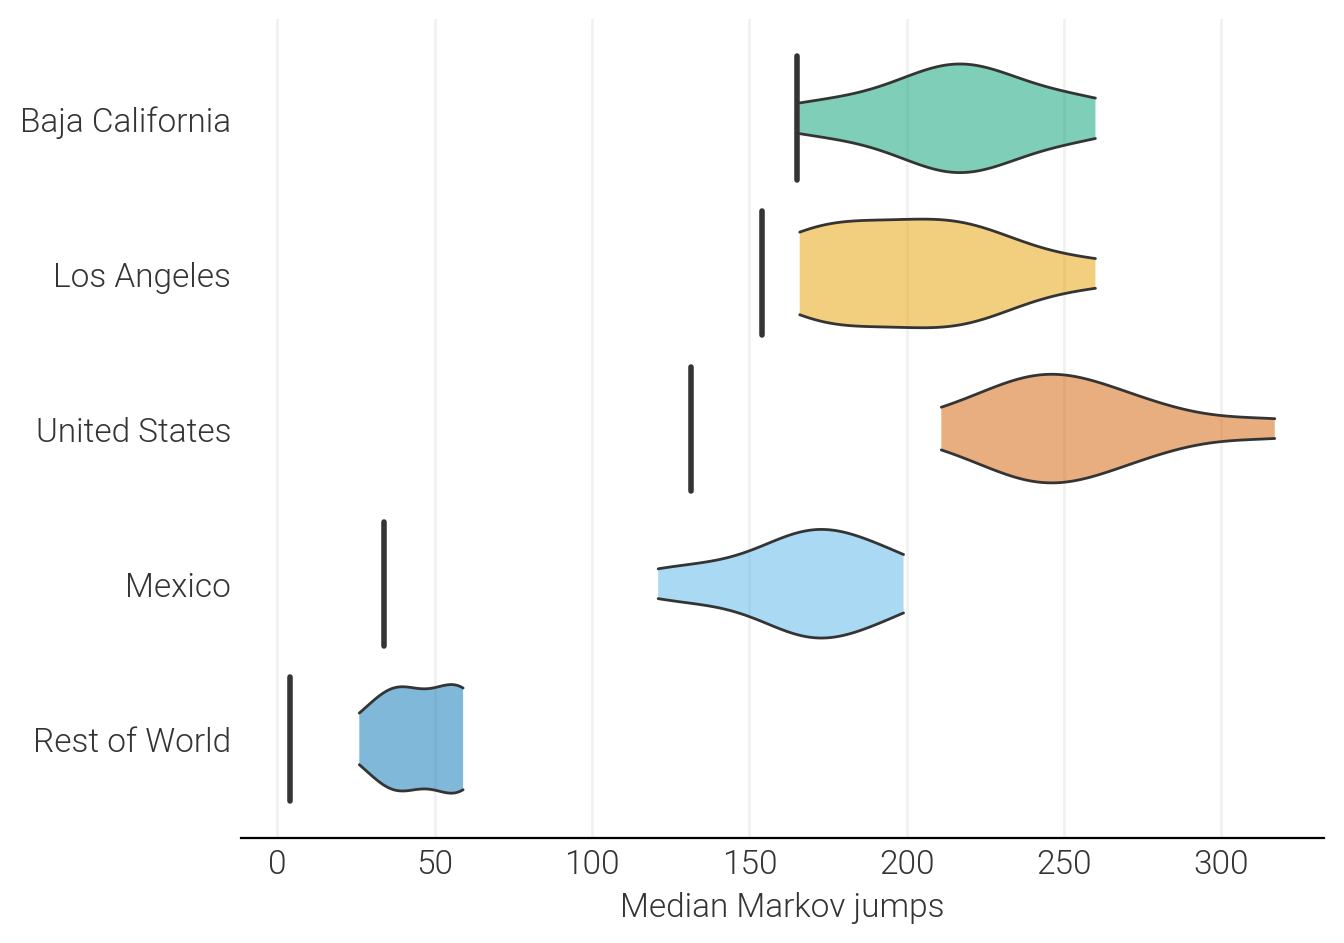

In [36]:
colors = [
    "#0072B2",
    "#56B4E9",
    "#D55E00",
    "#E69F00",
    "#009E73"
]

fig, ax = plt.subplots( dpi=200, figsize=(7,5) )
order = sd_jumps.groupby( "endLocation" )["time"].median().sort_values().index
medians = sd_jumps.groupby( "endLocation" )["time"].median().sort_values().reset_index()

for i, query in enumerate( order ):
    data = permutation.loc[permutation["location"]==query, "jumps"].to_numpy().ravel()
    data = data[~np.isnan(data)]
    data_median = np.median( data )

    hpdHi, hpdLo = hpd( data, 0.95 )
    x_grid = np.linspace( hpdLo, hpdHi, 101 )

    kde = gaussian_kde( data )
    y_grid = kde.evaluate( x_grid )
    y_grid = y_grid / y_grid.max() * 0.35

    ax.plot(x_grid, [i+y for y in y_grid], color=COLOR, lw=1, zorder=100, solid_capstyle="round" )
    ax.plot(x_grid, [i-y for y in y_grid], color=COLOR, lw=1, zorder=100, solid_capstyle="round" )

    ax.fill_between( x_grid, [i-y for y in y_grid], [i+y for y in y_grid], facecolor=colors[i], edgecolor='none', alpha=0.5, zorder=100 )

ln = ax.vlines( medians["time"], medians.index-0.4, medians.index+0.4, color=COLOR, linewidth=2, zorder=110 )
ln.set_capstyle( "round" )

ax.set_yticks( range( len( order ) ) )
ax.set_yticklabels( order )

basic_formatting( ax, which="x", xlabel="Median Markov jumps" )
ax.tick_params( axis="x", bottom=False, which="both", rotation=0, pad=0 )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure2_jumps-into-san-diego.pdf" )
plt.show()